In [1]:
import os, sys, pickle
import numpy as np
from copy import deepcopy
from tqdm import tqdm_notebook as tqdm
sys.path.append(os.path.join(os.getcwd(), '..'))
sys.path = list(set(sys.path))
import matplotlib.pyplot as plt
%matplotlib inline

from meir import MEIRTrainer
from flow.envs import WaveAttenuationMergePOEnv
from flow.utils.registry import make_create_env
from flow.utils.rllib import FlowParamsEncoder
import gym, ray
from ray import tune
from ray.rllib.agents.ppo import PPOAgent, DEFAULT_CONFIG
from ray.rllib.agents.ppo.ppo_policy_graph import PPOPolicyGraph
from ray.tune.registry import register_env
from ray.tune.logger import pretty_print
from ray.rllib.evaluation.sample_batch import DEFAULT_POLICY_ID

benchmark_name = 'multi_merge'
exp_name = 'v2v_benchmark'
results_list = os.listdir('/headless/ray_results/' + exp_name)
AGENT = 'PPO' # 'PPO' or 'DDPG' or 'HUMAN'
checkpoint = '100'

benchmark = __import__(
    "flow.benchmarks.%s" % benchmark_name, fromlist=["flow_params"])
flow_params = benchmark.buffered_obs_flow_params

ray.init(ignore_reinit_error=True)

2019-05-27 17:09:45,053	INFO node.py:469 -- Process STDOUT and STDERR is being redirected to /tmp/ray/session_2019-05-27_17-09-45_5555/logs.
2019-05-27 17:09:45,174	INFO services.py:407 -- Waiting for redis server at 127.0.0.1:57497 to respond...
2019-05-27 17:09:45,326	INFO services.py:407 -- Waiting for redis server at 127.0.0.1:16350 to respond...
2019-05-27 17:09:45,330	INFO services.py:804 -- Starting Redis shard with 10.0 GB max memory.
2019-05-27 17:09:45,394	INFO node.py:483 -- Process STDOUT and STDERR is being redirected to /tmp/ray/session_2019-05-27_17-09-45_5555/logs.
2019-05-27 17:09:45,398	INFO services.py:1427 -- Starting the Plasma object store with 18.23 GB memory using /dev/shm.


{'node_ip_address': '10.138.0.2',
 'object_store_address': '/tmp/ray/session_2019-05-27_17-09-45_5555/sockets/plasma_store',
 'raylet_socket_name': '/tmp/ray/session_2019-05-27_17-09-45_5555/sockets/raylet',
 'redis_address': '10.138.0.2:57497',
 'webui_url': None}

In [2]:
num_cpus = 23 
num_rollouts = 20
horizon = 750
gae_lambda = 0.97
step_size = 5e-4
num_iter = 10

config = deepcopy(DEFAULT_CONFIG)
config["num_workers"] = min(num_cpus, num_rollouts)
config["train_batch_size"] = horizon * num_rollouts
config["sample_batch_size"] = horizon / 2
config["use_gae"] = True
config["horizon"] = horizon
config["lambda"] = gae_lambda
config["lr"] = step_size
config["vf_clip_param"] = 1e6
config["num_sgd_iter"] = 10
config['clip_actions'] = False  # FIXME(ev) temporary ray bug
config["model"]["fcnet_hiddens"] = [128, 64, 32]
config["observation_filter"] = "NoFilter"
config["entropy_coeff"] = 0.0
config["num_train"] = 2
config["expert_path"] = './expert_sample'
config["theta_lr"] = 0.01

benchmark_name = "multi_merge"
benchmark = __import__(
            "flow.benchmarks.%s" % benchmark_name, fromlist=["flow_params"])
flow_params = benchmark.buffered_obs_flow_params
flow_params["env"].additional_params["buf_length"] = 1
create_env, env_name = make_create_env(params=flow_params, version=0)
env = create_env()
register_env(env_name, create_env)

default_policy = (PPOPolicyGraph, env.observation_space, env.action_space, {})
policy_graph = {DEFAULT_POLICY_ID: default_policy}
config["multiagent"] = {
        'policy_graphs': policy_graph,
        'policy_mapping_fn': tune.function(lambda agent_id: DEFAULT_POLICY_ID)
    }

In [3]:
agent = MEIRTrainer(config, env_name)

2019-05-27 17:09:48,998	INFO policy_evaluator.py:311 -- Creating policy evaluation worker 0 on CPU (please ignore any CUDA init errors)
/opt/conda/envs/flow-latest/lib/python3.5/site-packages/tensorflow/python/ops/gradients_impl.py:108: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "
2019-05-27 17:09:50,690	INFO policy_evaluator.py:728 -- Built policy map: {'default_policy': <ray.rllib.agents.ppo.ppo_policy_graph.PPOPolicyGraph object at 0x7f6144414ba8>}
2019-05-27 17:09:50,692	INFO policy_evaluator.py:729 -- Built preprocessor map: {'default_policy': <ray.rllib.models.preprocessors.NoPreprocessor object at 0x7f6144414898>}
2019-05-27 17:09:50,693	INFO policy_evaluator.py:343 -- Built filter map: {'default_policy': <ray.rllib.utils.filter.NoFilter object at 0x7f61443fde48>}
2019-05-27 17:09:50,729	WARNING worker.py:334 -- WARNING: Falling 

In [4]:
with open('1buf.wgt', 'rb') as f:
    weights = pickle.load(f)
    weights[DEFAULT_POLICY_ID] = weights.pop('default')
    
agent.set_weights(weights)

In [5]:
render = False
env = None
if render:
    env = make_vis_env(flow_params, MultiWaveAttenuationMergePOEnv, MergeScenario)
else: 
    env = create_env()

In [6]:
# calculate the space-time velocity map
left_length = env.k.scenario.edge_length('left')
car_length = 5.0
scale = 10
vel_lists = []
vel_map_lists = []
outflow_lists = []

num_iter = 1
for _ in tqdm(range(num_iter)):
    state = env.reset(False)
    vel = []
    outflow = []
    for i in tqdm(range(750)):
        # record the mean velocity
        v = np.mean(env.k.vehicle.get_speed(env.k.vehicle.get_ids()))
        vel.append(v)

        # record the velocity map
        ids = env.k.vehicle.get_ids_by_edge('left')
        vel_map_ = np.zeros(int(left_length)*scale)
        for id_ in ids:
            pos_ = np.round(env.k.vehicle.get_position(id_), decimals=1)
            vel_ = max(env.k.vehicle.get_speed(id_), 0)
            pos_bottom = max(0, int((pos_-car_length/2.0)*scale))
            pos_top = min(int(left_length)*scale, int((pos_+car_length/2.0)*scale))
            vel_map_[pos_bottom:pos_top] = vel_            

        # step the simulation
        rl_ids = env.k.vehicle.get_rl_ids()
        actions = {}
        if AGENT != 'HUMAN':
            for id_ in rl_ids:
                current_edge = env.k.vehicle.get_edge(id_)
                # if 'inflow' in current_edge:
                #     continue
                
                action = agent.compute_action(state[id_])
                actions.update({id_: action})
        # actions = agent.compute_action(state)
        state, r, _, _ = env.step(actions)
        outflow.append(env.k.vehicle.get_outflow_rate(600)) # measured by one min

        if i == 0:
            vel_map_list = vel_map_
        else:
            vel_map_list = np.vstack((vel_map_list, vel_map_))

    outflow_lists.append(outflow[-500:])
    vel_lists.append(vel)
    vel_map_list[vel_map_list==0.0] = np.nan
    vel_map_lists.append(vel_map_list)

(pid=19161) Loading configuration... done.
(pid=19161) Success.
(pid=19194) Loading configuration... done.
(pid=19194) Success.
(pid=19168) Loading configuration... done.
(pid=19168) Success.
(pid=19161) Loading configuration... done.
(pid=19194) Loading configuration... done.
(pid=19210) Loading configuration... done.
(pid=19198) Loading configuration... done.
(pid=19168) Loading configuration... done.
(pid=19210) Success.
(pid=19198) Success.
(pid=19210) Loading configuration... done.
(pid=19198) Loading configuration... done.
(pid=19178) Loading configuration... done.
(pid=19178) Success.
(pid=19178) Loading configuration... done.
(pid=19186) Loading configuration... done.
(pid=19186) Success.
(pid=19172) Loading configuration... done.


2019-05-27 07:09:29,258	INFO tf_run_builder.py:89 -- Executing TF run without tracing. To dump TF timeline traces to disk, set the TF_TIMELINE_DIR environment variable.


(pid=19186) Loading configuration... done.
(pid=19188) Loading configuration... done.
(pid=19172) Success.
(pid=19172) Loading configuration... done.
(pid=19188) Success.
(pid=19187) Loading configuration... done.
(pid=19188) Loading configuration... done.
(pid=19219) Loading configuration... done.
(pid=19187) Success.
(pid=19219) Success.
(pid=19214) Loading configuration... done.
(pid=19187) Loading configuration... done.
(pid=19179) Loading configuration... done.
(pid=19218) Loading configuration... done.
(pid=19219) Loading configuration... done.
(pid=19214) Success.
(pid=19179) Success.
(pid=19218) Success.
(pid=19218) Loading configuration... done.
(pid=19214) Loading configuration... done.
(pid=19179) Loading configuration... done.
(pid=19177) Loading configuration... done.
(pid=19177) Success.
(pid=19177) Loading configuration... done.
(pid=19156) Loading configuration... done.
(pid=19156) Success.
(pid=19171) Loading configuration... done.
(pid=19197) Loading configuration... 

(pid=19188) /opt/conda/envs/flow-latest/lib/python3.5/site-packages/tensorflow/python/ops/gradients_impl.py:108: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
(pid=19188)   "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "
(pid=19156) 2019-05-27 07:09:30,633	INFO policy_evaluator.py:311 -- Creating policy evaluation worker 16 on CPU (please ignore any CUDA init errors)
(pid=19156) 2019-05-27 07:09:30.635743: I tensorflow/core/platform/cpu_feature_guard.cc:141] Your CPU supports instructions that this TensorFlow binary was not compiled to use: AVX2 AVX512F FMA
(pid=19187) /opt/conda/envs/flow-latest/lib/python3.5/site-packages/tensorflow/python/ops/gradients_impl.py:108: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
(pid=19187)   "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "
(pid=19171) 2

(pid=19214) Closing connection to TraCI and stopping simulation.
(pid=19214) Note, this may print an error message when it closes.
(pid=19197) Closing connection to TraCI and stopping simulation.
(pid=19197) Note, this may print an error message when it closes.
(pid=19171) Closing connection to TraCI and stopping simulation.
(pid=19171) Note, this may print an error message when it closes.
(pid=19207) Closing connection to TraCI and stopping simulation.
(pid=19207) Note, this may print an error message when it closes.
(pid=19189) Closing connection to TraCI and stopping simulation.
(pid=19189) Note, this may print an error message when it closes.
(pid=19205) Loading configuration... done.
(pid=19205) Success.
(pid=19206) Loading configuration... done.
(pid=19205) Loading configuration... done.
(pid=19192) Loading configuration... done.
(pid=19206) Success.
(pid=19192) Success.
(pid=19192) Loading configuration... done.
(pid=19206) Loading configuration... done.
(pid=19200) Loading conf

(pid=19196) 2019-05-27 07:09:41,032	INFO policy_evaluator.py:311 -- Creating policy evaluation worker 11 on CPU (please ignore any CUDA init errors)
(pid=19196) 2019-05-27 07:09:41.034452: I tensorflow/core/platform/cpu_feature_guard.cc:141] Your CPU supports instructions that this TensorFlow binary was not compiled to use: AVX2 AVX512F FMA
(pid=19174) /opt/conda/envs/flow-latest/lib/python3.5/site-packages/tensorflow/python/ops/gradients_impl.py:108: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
(pid=19174)   "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "
(pid=19162) 2019-05-27 07:09:41,085	INFO policy_evaluator.py:311 -- Creating policy evaluation worker 17 on CPU (please ignore any CUDA init errors)
(pid=19162) 2019-05-27 07:09:41.087816: I tensorflow/core/platform/cpu_feature_guard.cc:141] Your CPU supports instructions that this TensorFlow binary was not compiled to use: AVX2 AVX5

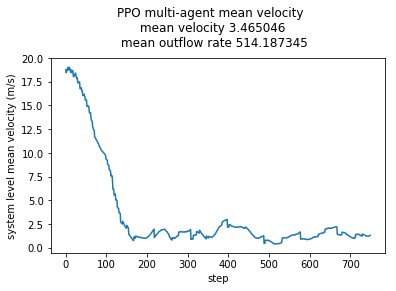

In [7]:
vel_fig, ax = plt.subplots(nrows=1, ncols=1)
for i in range(num_iter):
    ax.plot(vel_lists[i])
title = AGENT + ' multi-agent mean velocity'
title = title + ' \n mean velocity {:3f}'.format(np.mean(vel_lists))
title = title + ' \n mean outflow rate {:3f}'.format(np.mean(outflow_lists))
ax.set_ylabel('system level mean velocity (m/s)')
ax.set_xlabel('step')
vel_fig.suptitle(title)
plt.subplots_adjust(top=0.8)

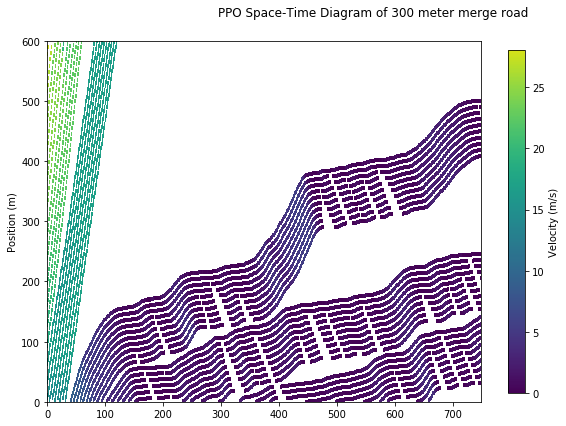

In [8]:
nrows = 1 
ncols = 1
space_fig, axes = plt.subplots(nrows=nrows, ncols=ncols, figsize=(10, 6))
space_fig.tight_layout()

for i in range(num_iter):
    # plt.subplot(2, 3, i+1)
    x = np.arange(int(750))
    y = np.arange(0, int(left_length), step=0.1)
    xx, yy = np.meshgrid(x, y)
    try:
        im = axes[i%2, i%3].pcolormesh(xx, yy, vel_map_lists[i].T)
        if i % 3 == 0:
            axes[i%2, i%3].set_ylabel('Position (m)')
        if int(i / 3.0) > 0:
            axes[int(i/3), int(i/3)].set_xlabel('step')
    except:
        im = axes.pcolormesh(xx, yy, vel_map_lists[i].T)
        if i % 3 == 0:
            axes.set_ylabel('Position (m)')
        if int(i / 3.0) > 0:
            axes.set_xlabel('step')
        
try:
    clb = space_fig.colorbar(im, ax=axes.ravel().tolist(), shrink=0.95)
except:
    clb = space_fig.colorbar(im, ax=axes, shrink=0.95)
    
clb.set_clim(0, 30)
clb.set_label('Velocity (m/s)')
title = AGENT + ' Space-Time Diagram of 300 meter merge road'
space_fig.suptitle(title)   
plt.subplots_adjust(top=0.9, right=0.8)

In [19]:
if not render:
    if AGENT == 'HUMAN':
        filename = 'HUMAN.png'
        vel_dir = '../result/MultiMerge/' + AGENT + '/mean_velocity/'
        space_dir = '../result/MultiMerge/' + AGENT + '/space_time_diagram/'
    else:
        filename = PATH[PATH.find('/') + 1:].replace(' ', '_') + '.png'
        vel_dir = '../result/MultiMerge/' + AGENT + '/' + exp_name + '/mean_velocity/'
        space_dir = '../result/MultiMerge/' + AGENT + '/' + exp_name + '/space_time_diagram/'
    os.makedirs(vel_dir, exist_ok=True)
    os.makedirs(space_dir, exist_ok=True)

    vel_fig.savefig(vel_dir + filename)
    space_fig.savefig(space_dir + filename)

In [20]:
good_samples = agent.sample(agent.train_batch_size)

(pid=5690) Loading configuration... done.
(pid=5722) Warning: Teleporting vehicle 'flow_1.3'; collision with vehicle 'flow_2.3', lane=':center_1_0', gap=-1.00, time=123.00 stage=move.
(pid=5690) Success.
(pid=5690) Loading configuration... done.
(pid=5722) Loading configuration... done.
(pid=5722) Success.
(pid=5722) Loading configuration... done.
(pid=5738) Loading configuration... done.
(pid=5738) Success.
(pid=5721) Loading configuration... done.
(pid=5721) Success.
(pid=5741) Loading configuration... done.
(pid=5741) Success.
(pid=5738) Loading configuration... done.
(pid=5710) Loading configuration... done.
(pid=5710) Success.
(pid=5721) Loading configuration... done.
(pid=5741) Loading configuration... done.
(pid=5710) Loading configuration... done.
(pid=5719) Loading configuration... done.
(pid=5719) Success.
(pid=5719) Loading configuration... 
(pid=5719) done.
(pid=5715) Loading configuration... done.
(pid=5715) Success.
(pid=5739) Loading configuration... done.
(pid=5739) Suc

In [13]:
from ray.rllib.evaluation.postprocessing import discount

In [21]:
rewds = good_samples[good_samples.REWARDS]

In [22]:
returns = discount(rewds, 0.99)

In [23]:
for t, r, R, d in zip(good_samples["t"], rewds, returns, good_samples[good_samples.DONES]):
    print(t, r, R, d)

50 -0.3679783 -38.97737710034531 False
51 -0.36496416 -38.999392722950255 False
52 -0.36178872 -39.024675318795296 False
53 -0.35916162 -39.05342080697252 False
54 -0.38051683 -39.085110294546276 False
55 -0.37729296 -39.095548957009896 False
56 -0.3738503 -39.10934949103809 False
57 -0.3702496 -39.12676687376885 False
58 -0.3759931 -39.14799724702069 False
59 -0.3864753 -39.16364054972905 False
60 -0.38256666 -39.168853792828926 False
61 -0.3785457 -39.17806781028919 False
62 -0.3743967 -39.191436473520646 False
63 -0.37962666 -39.20913107265933 False
64 -0.38930193 -39.221721627394196 False
65 -0.38510537 -39.22466636514808 False
66 -0.3807452 -39.23187979158875 False
67 -0.37622455 -39.2435702922079 False
68 -0.38108954 -39.2599451965488 False
69 -0.3901918 -39.271571371932325 False
70 -0.38563165 -39.274120786354096 False
71 -0.38090622 -39.28130215724023 False
72 -0.3759708 -39.29332922524186 False
73 -0.37084052 -39.310463045040485 False
74 -0.37084052 -39.33295204583214 True
50 

248 -0.41745278 -39.87963111275519 False
249 -0.41352132 -39.860786192285545 False
250 -0.4095421 -39.84572209359372 False
251 -0.40545958 -39.834525232374915 False
252 -0.41480023 -39.82733903996897 False
253 -0.4111948 -39.81064526593998 False
254 -0.40744433 -39.797424711726684 False
255 -0.40334815 -39.787858973390904 False
256 -0.39881146 -39.78233416719373 False
257 -0.39407355 -39.78133606833577 False
258 -0.40305856 -39.78511365899293 False
259 -0.3985199 -39.77985363665703 False
260 -0.40186763 -39.77912498306629 False
261 -0.4185106 -39.77500742926137 False
262 -0.41267842 -39.75403721539196 False
263 -0.41865528 -39.73874625742251 False
264 -0.413304 -39.71726361729696 False
265 -0.40783307 -39.700969309297015 False
266 -0.40987137 -39.690036605792024 False
267 -0.40370852 -39.676934582011846 False
268 -0.4100955 -39.66992531763679 False
269 -0.40511668 -39.65639374219173 False
270 -0.39965603 -39.64775461101767 False
271 -0.3941842 -39.6445440236992 False
272 -0.39652297 -3

79 -0.50388753 -48.59240496754309 False
80 -0.50278944 -48.57426003373894 False
81 -0.5108711 -48.55704100602838 False
82 -0.51177603 -48.531484741092655 False
83 -0.5096705 -48.504756273766695 False
84 -0.51357466 -48.47988462401996 False
85 -0.512821 -48.45081814565211 False
86 -0.51166964 -48.42221932015786 False
87 -0.51090723 -48.39449463069207 False
88 -0.5082406 -48.36725999790979 False
89 -0.5129778 -48.34244385591012 False
90 -0.51151794 -48.31259199696821 False
91 -0.5096538 -48.28391318688531 False
92 -0.5071021 -48.256827656766575 False
93 -0.5086421 -48.23204604497743 False
94 -0.50569284 -48.205458553062066 False
95 -0.5028251 -48.18158152872684 False
96 -0.49801055 -48.16036004785699 False
97 -0.49320146 -48.14378737564443 False
98 -0.49320146 -48.13190496083821 True
50 -0.47057915 -48.119902521640014 False
51 -0.4724637 -48.13062967101126 False
52 -0.47930622 -48.139561589713345 False
53 -0.47947538 -48.14167208960106 False
54 -0.48216018 -48.1436330410211 False
55 -0.4

243 -0.39946422 -40.76625666927182 False
244 -0.4092087 -40.774537827740645 False
245 -0.40406147 -40.773059739980766 False
246 -0.4119616 -40.77676593285385 False
247 -0.40717173 -40.772529644010675 False
248 -0.4026785 -40.77308880584229 False
249 -0.41257817 -40.77819223854266 False
250 -0.42117697 -40.77334754849647 False
251 -0.4171095 -40.75976826110246 False
252 -0.41316235 -40.750160375415696 False
253 -0.40913355 -40.74444244925363 False
254 -0.41816816 -40.74273625833201 False
255 -0.41406924 -40.73188697069991 False
256 -0.4243243 -40.72506841957076 False
257 -0.42040062 -40.70782233909629 False
258 -0.43000123 -40.69436537332268 False
259 -0.42589295 -40.67107489320698 False
260 -0.42177472 -40.65169893343704 False
261 -0.44057304 -40.63628708914331 False
262 -0.44661933 -40.60173136613396 False
263 -0.4420647 -40.56071922656289 False
264 -0.43725428 -40.52389345863844 False
265 -0.43240163 -40.491554726047 False
266 -0.42746893 -40.46379100883316 False
267 -0.4340391 -40.4

62 -0.52769476 -47.064827028683496 False
63 -0.526927 -47.00720431003072 False
64 -0.5299748 -46.9497750663707 False
65 -0.5289894 -46.888687119334364 False
66 -0.52813894 -46.82797751989572 False
67 -0.52973366 -46.76751372154522 False
68 -0.52838945 -46.70482834718011 False
69 -0.53109604 -46.64286756898199 False
70 -0.52989703 -46.57754699775702 False
71 -0.5285411 -46.512777740998764 False
72 -0.52994996 -46.44872389181264 False
73 -0.5287349 -46.382599927999834 False
74 -0.5276584 -46.317035359182604 False
75 -0.53117007 -46.251895915417 False
76 -0.5298136 -46.18255135883398 False
77 -0.5281891 -46.113876536533766 False
78 -0.5269528 -46.046148902885776 False
79 -0.5254206 -45.9789859593443 False
80 -0.5284881 -45.91269227596766 False
81 -0.53641444 -45.842630481204665 False
82 -0.5337508 -45.76385458258394 False
83 -0.5316158 -45.686973545563376 False
84 -0.52920556 -45.611472476624634 False
85 -0.53224415 -45.53764334943478 False
86 -0.53058535 -45.45999919551977 False
87 -0.52

182 -0.4131185 -38.899712444970156 False
183 -0.42091668 -38.87534740760786 False
184 -0.41603678 -38.84285932432986 False
185 -0.4111364 -38.814972262304 False
186 -0.40618747 -38.791753407601334 False
187 -0.40116537 -38.773298922094654 False
188 -0.4093258 -38.75973086456754 False
189 -0.40451288 -38.73778288513219 False
190 -0.39944667 -38.72047475040356 False
191 -0.39422634 -38.70810917592209 False
192 -0.38887516 -38.70089175099236 False
193 -0.3833915 -38.69900666096097 False
194 -0.39189118 -38.70264157721376 False
195 -0.3866636 -38.69772767246949 False
196 -0.3866636 -38.6980445318871 True
141 -0.38119805 -38.69836459190489 False
142 -0.38597414 -38.70420862960937 False
143 -0.38080844 -38.705287364277 False
144 -0.37563196 -38.71159487014744 False
145 -0.37036118 -38.72319486050627 False
146 -0.37506393 -38.74023604181099 False
147 -0.38499415 -38.752699106898454 False
148 -0.38103676 -38.75525753302059 False
149 -0.37739342 -38.761839166260344 False
150 -0.37423277 -38.772

40 -0.32281122 -39.936686932864355 False
41 -0.32748938 -40.01401587550344 False
42 -0.34290454 -40.08740050448012 False
43 -0.34025976 -40.14595552178176 False
44 -0.3388772 -40.207773496124794 False
45 -0.3367771 -40.27161241923684 False
46 -0.3434647 -40.338217503242966 False
47 -0.3577129 -40.39874020290423 False
48 -0.3551477 -40.445482129521324 False
49 -0.35242656 -40.49528731307112 False
50 -0.358587 -40.548344196301144 False
51 -0.35589603 -40.595714342936766 False
52 -0.35274497 -40.646281128323935 False
53 -0.3655993 -40.70054157735208 False
54 -0.3714361 -40.74236593223681 False
55 -0.36800545 -40.77871701309044 False
56 -0.36440888 -40.81890056419211 False
57 -0.3606358 -40.86312291284841 False
58 -0.37203276 -40.91160315717151 False
59 -0.37757462 -40.949061005654265 False
60 -0.37369856 -40.98129937679111 False
61 -0.36963394 -41.017778600411575 False
62 -0.3653715 -41.05873197734252 False
63 -0.38504088 -41.104404527128494 False
64 -0.38075078 -41.13067035139285 False
6

300 -0.4384638 -45.809023612841635 False
301 -0.43457487 -45.828848288621835 False
302 -0.4305815 -45.85280143067324 False
303 -0.426449 -45.881030222834596 False
304 -0.42214277 -45.91371840605978 False
305 -0.4285992 -45.95108649716477 False
306 -0.4285992 -45.982310392496366 True
238 -0.57914513 -46.0138496807101 False
239 -0.5792341 -45.8936409567826 False
240 -0.57640874 -45.77212811469961 False
241 -0.5729833 -45.65224178872856 False
242 -0.5693227 -45.53460450929376 False
243 -0.565344 -45.41947656972212 False
244 -0.56342125 -45.307204640102334 False
245 -0.5586591 -45.19574079869968 False
246 -0.5553703 -45.087961335362635 False
247 -0.5568756 -44.982415216319936 False
248 -0.5528064 -44.87428245435377 False
249 -0.5490185 -44.76916775448776 False
250 -0.5445125 -44.666817426517525 False
251 -0.5398484 -44.56798476385641 False
252 -0.54335344 -44.47286502688389 False
253 -0.53907746 -44.37324402879445 False
254 -0.53548914 -44.27693592730163 False
255 -0.53186995 -44.183279581

77 -0.50002164 -48.156568437203305 False
78 -0.4981618 -48.13792606133056 False
79 -0.5002118 -48.12097400866205 False
80 -0.50306684 -48.10178003369613 False
81 -0.5107954 -48.07950827869546 False
82 -0.5093054 -48.04920491338149 False
83 -0.5077431 -48.02010050085232 False
84 -0.50640374 -47.992280182483675 False
85 -0.51014715 -47.965531755821154 False
86 -0.5093037 -47.93473192069692 False
87 -0.5078686 -47.904472961307 False
88 -0.5049792 -47.87535795286492 False
89 -0.50669396 -47.84886743399426 False
90 -0.50313365 -47.82037724723042 False
91 -0.49918464 -47.79519554811717 False
92 -0.49516988 -47.77374839379331 False
93 -0.49046478 -47.756139914936696 False
94 -0.4957721 -47.74310620018416 False
95 -0.49129236 -47.724579905706754 False
96 -0.48665738 -47.710391462890904 False
97 -0.48226625 -47.70074149680118 False
98 -0.477403 -47.695429544978474 False
99 -0.47762194 -47.69497629301028 False
100 -0.47914106 -47.69429732348658 False
101 -0.47483423 -47.69207703732217 False
102 

130 -0.38079813 -41.696325410154756 False
131 -0.37547776 -41.732855837300264 False
132 -0.3947526 -41.77512936996976 False
133 -0.38952032 -41.798360381940796 False
134 -0.38416788 -41.82711117638863 False
135 -0.37869415 -41.86155888542299 False
136 -0.37310207 -41.90188357429437 False
137 -0.39204058 -41.94826414686192 False
138 -0.38707763 -41.97598340035437 False
139 -0.38219434 -42.00899572806887 False
140 -0.3774913 -42.04727412913115 False
141 -0.37249804 -42.09068973110452 False
142 -0.37697846 -42.13958757138749 False
143 -0.37167197 -42.184453650922684 False
144 -0.38194713 -42.23513300632699 False
145 -0.3780541 -42.27594532965875 False
146 -0.37465996 -42.32110223986139 False
147 -0.38098276 -42.37014372157559 False
148 -0.37831062 -42.41329390400091 False
149 -0.3766323 -42.45957907395571 False
150 -0.3752479 -42.508027041369914 False
151 -0.37454563 -42.55836277338616 False
152 -0.383747 -42.609916302619474 False
153 -0.3826815 -42.6526962537337 False
154 -0.38084298 -42

321 -0.45435467 -40.130513417632365 False
322 -0.45172384 -40.07692802425083 False
323 -0.4488893 -40.02545876811908 False
324 -0.4453512 -39.9763328109021 True
0 -0.3416087 -39.930284442106384 False
1 -0.33521286 -39.98856135249489 False
2 -0.3286033 -40.05388736966035 False
3 -0.32165086 -40.12654956786702 False
4 -0.31459162 -40.206968389063874 False
5 -0.32673112 -40.2953300734058 False
6 -0.3203447 -40.37232217962242 False
7 -0.31371644 -40.45654292233762 False
8 -0.30691603 -40.54830957671184 False
9 -0.31897122 -40.64787227116228 False
10 -0.31804153 -40.73626369139764 False
11 -0.3118138 -40.82648702845041 False
12 -0.30546638 -40.92391235042766 False
13 -0.29907373 -41.02873329972935 False
14 -0.3122973 -41.14107027655612 False
15 -0.30679256 -41.24118481025321 False
16 -0.3061606 -41.34787096264008 False
17 -0.30078554 -41.4562730945927 False
18 -0.2951677 -41.57119954854372 False
19 -0.2896571 -41.692961448673074 False
20 -0.30407768 -41.82151955812032 False
21 -0.30047104 -

102 -0.37925124 -41.00502189215094 False
103 -0.39048985 -41.03613197016867 False
104 -0.39691997 -41.05620416535424 False
105 -0.3927685 -41.069984040010326 False
106 -0.38894296 -41.08809650280294 False
107 -0.38523334 -41.11025610694798 False
108 -0.38201973 -41.136386630606495 False
109 -0.4042607 -41.16602717392357 False
110 -0.4011152 -41.173501493881766 False
111 -0.39717174 -41.184228570724805 False
112 -0.3931964 -41.19904730804167 False
113 -0.38914928 -41.21803121622365 False
114 -0.39597216 -41.2412948866882 False
115 -0.40588292 -41.25790174161927 False
116 -0.40129864 -41.264665471539516 False
117 -0.39762658 -41.276128110485864 False
118 -0.3938076 -41.29141568856367 False
119 -0.38970703 -41.310715251066554 False
120 -0.39950055 -41.334351739596705 False
121 -0.39546016 -41.34833453611832 False
122 -0.3912065 -41.366539775284664 False
123 -0.38674387 -41.3892255276467 False
124 -0.3820769 -41.41664813564538 False
125 -0.39137492 -41.44906186501907 False
126 -0.38691142 

292 -0.43300983 -43.158289547297585 False
293 -0.42834032 -43.15684819616175 False
294 -0.42615023 -43.160108970043396 False
295 -0.43063942 -43.165614886353445 False
296 -0.42666876 -43.16664188926673 False
297 -0.45786464 -43.17169002636972 False
298 -0.45616296 -43.14527816588532 False
299 -0.4543998 -43.12031839045262 False
300 -0.46158767 -43.09688747082069 False
301 -0.45913246 -43.06595939732877 False
302 -0.4563492 -43.0371989238271 False
303 -0.4539337 -43.010959323007334 False
304 -0.4624216 -42.98689458281752 False
305 -0.45999232 -42.95401311794672 False
306 -0.4574026 -42.923253331920456 False
307 -0.46374333 -42.89479873230657 False
308 -0.47250503 -42.859651922483245 False
309 -0.46991703 -42.815299888350545 False
310 -0.46768114 -42.77311399920017 False
311 -0.47695935 -42.732760464133946 False
312 -0.47442767 -42.682627390312156 False
313 -0.47188622 -42.634545171789654 False
314 -0.4695371 -42.588544398177284 False
315 -0.47568905 -42.54445180711182 False
316 -0.47302

97 -0.52106 -53.20745558679372 False
98 -0.5198651 -53.21858141097427 False
99 -0.51971084 -53.23102658117059 False
100 -0.51391 -53.243753275127155 False
101 -0.5085369 -53.262467959162905 False
102 -0.5026987 -53.286799074661566 False
103 -0.49718928 -53.31727308602027 False
104 -0.50205255 -53.35362000267606 False
105 -0.49745458 -53.38542167386725 False
106 -0.4926007 -53.42218898002261 False
107 -0.48864466 -53.46423057658859 False
108 -0.48971865 -53.510692845524645 False
109 -0.48612913 -53.556539595670266 False
110 -0.48237845 -53.606475212905906 False
111 -0.48425686 -53.66070379786831 False
112 -0.4815119 -53.713582761893186 False
113 -0.48416683 -53.76976855657068 False
114 -0.4821556 -53.82384012706319 False
115 -0.47924918 -53.88048943011488 False
116 -0.47652027 -53.94064671793094 False
117 -0.51903373 -54.00416812911289 False
118 -0.51523507 -54.02538828190185 False
119 -0.5114599 -54.05065981362421 False
120 -0.50708187 -54.07999992585502 False
121 -0.50439465 -54.11405

254 -0.43455654 -42.1959126658698 False
255 -0.42916572 -42.183188002063375 False
256 -0.42380017 -42.175780081943174 False
257 -0.4184663 -42.17371708234502 False
258 -0.42457363 -42.17702099249774 False
259 -0.43227744 -42.174189254952736 False
260 -0.42744222 -42.16354728679592 False
261 -0.4439032 -42.157681882790186 False
262 -0.45007744 -42.13512997475885 False
263 -0.44516653 -42.10611366711504 False
264 -0.4404932 -42.081764786757674 False
265 -0.44691554 -42.0618904954633 False
266 -0.4424545 -42.03532824075191 False
267 -0.45025828 -42.01300379158239 False
268 -0.44590628 -41.982571218964836 False
269 -0.44159964 -41.95622720958948 False
270 -0.43726265 -41.933967244767175 False
271 -0.4328282 -41.915863222689566 False
272 -0.4402138 -41.902055590653596 False
273 -0.43601856 -41.88064827391614 False
274 -0.43183655 -41.8632623409694 False
275 -0.42767447 -41.84992504596164 False
276 -0.42337617 -41.84065714508044 False
277 -0.4188529 -41.83563734575702 False
278 -0.42629442 -

18 -0.295933 -48.64124227785261 False
19 -0.2893812 -48.83364572692792 False
20 -0.3037018 -49.03461062716394 False
21 -0.3000467 -49.22314024139082 False
22 -0.29677293 -49.41726619114213 False
23 -0.30055323 -49.616659862723544 False
24 -0.29810637 -49.8142491215072 False
25 -0.29728204 -50.01630580722302 False
26 -0.36399293 -50.22123612838773 False
27 -0.3922695 -50.36085171609001 False
28 -0.40501422 -50.47331537771784 False
29 -0.40850282 -50.5740415765838 False
30 -0.4114058 -50.67226137316149 False
31 -0.42364043 -50.768540981200424 False
32 -0.42596194 -50.85343490022911 False
33 -0.43804586 -50.936841372473204 False
34 -0.4406354 -51.00888435670338 False
35 -0.4434154 -51.07903933714338 False
36 -0.45408303 -51.14709488260332 False
37 -0.4570015 -51.20506248196752 False
38 -0.47005954 -51.26066765119724 False
39 -0.47297695 -51.303644552877984 False
40 -0.47593984 -51.34410868695633 False
41 -0.4782791 -51.38198873422018 False
42 -0.48634216 -51.41788850550571 False
43 -0.489

179 -0.46431208 -43.60564933702439 False
180 -0.46039584 -43.577108343894736 False
181 -0.46078676 -43.55223484960013 False
182 -0.45622754 -43.52671524216846 False
183 -0.46042386 -43.50554313252385 False
184 -0.4562964 -43.479918460151715 False
185 -0.45208612 -43.45820408688367 False
186 -0.45267668 -43.44052319801998 False
187 -0.44890007 -43.42206718621784 False
188 -0.44485986 -43.40723950752639 False
189 -0.44098005 -43.3963430759584 False
190 -0.44183463 -43.389255584819054 False
191 -0.43768555 -43.38123328912834 False
192 -0.44409782 -43.37732094936278 False
193 -0.43994075 -43.366892052948145 False
194 -0.44107682 -43.360556871059835 False
195 -0.4368903 -43.353010157506574 False
196 -0.4325971 -43.349616013553515 False
197 -0.4281651 -43.35052415436243 False
198 -0.4346349 -43.3559182286838 False
199 -0.43557867 -43.3548316510618 False
200 -0.4314866 -43.352780784832134 False
201 -0.42739004 -43.354842604277 False
202 -0.4232342 -43.3610631972827 False
203 -0.42420223 -43.3

50 -0.3525755 -39.084669268066584 False
51 -0.35863832 -39.12332702760233 False
52 -0.37056777 -39.15625122344387 False
53 -0.36707044 -39.177458034981505 False
54 -0.3634561 -39.202411715660446 False
55 -0.359709 -39.23126829841919 False
56 -0.36457056 -39.26420131696181 False
57 -0.37524724 -39.29255632211179 False
58 -0.37136462 -39.310413214187136 False
59 -0.36732468 -39.332372314019146 False
60 -0.3721436 -39.35863397366585 False
61 -0.36759865 -39.38029331035869 False
62 -0.37755996 -39.40676228032225 False
63 -0.37334746 -39.42343668730686 False
64 -0.37806344 -39.44453457180127 False
65 -0.3734882 -39.46108195098828 False
66 -0.3685314 -39.48241794262461 False
67 -0.37817168 -39.50897629969582 False
68 -0.37366974 -39.526065270038416 False
69 -0.3779397 -39.54787426919244 False
70 -0.37273967 -39.565590472840526 False
71 -0.36736414 -39.588738181999695 False
72 -0.3766058 -39.617549539025156 False
73 -0.3766058 -39.63731689928309 True
15 -0.3162047 -39.65728392984666 False
16 

157 -0.48500434 -43.993358639707374 False
158 -0.48147544 -43.947832630369206 False
159 -0.47885078 -43.90541130072856 False
160 -0.48075885 -43.865212645263625 False
161 -0.48203656 -43.82268060551263 False
162 -0.47966722 -43.77842832801897 False
163 -0.477135 -43.73612233482786 False
164 -0.47517443 -43.695946800216966 False
165 -0.47359645 -43.65734583149949 False
166 -0.47719055 -43.61994886649778 False
167 -0.4767457 -43.578543749854326 False
168 -0.4760116 -43.537169752503644 False
169 -0.47354016 -43.4961193418515 False
170 -0.4763812 -43.45715069168869 False
171 -0.4872333 -43.41491866587452 False
172 -0.48273063 -43.361298338319834 False
173 -0.47740054 -43.31168455682818 False
174 -0.47180584 -43.26695355103297 False
175 -0.47236022 -43.227421929598286 False
176 -0.47392035 -43.186931016228854 False
177 -0.46783558 -43.144455223154 False
178 -0.46137485 -43.10769661395133 False
179 -0.4617181 -43.077092691788174 False
180 -0.45599958 -43.045832908644314 False
181 -0.45029986

19 -0.2892599 -37.13502251207464 False
20 -0.3046153 -37.217942021708225 False
21 -0.30118018 -37.28618861892462 False
22 -0.303984 -37.358594378825394 False
23 -0.30246314 -37.42889938631079 False
24 -0.30227825 -37.50145074974428 False
25 -0.30195436 -37.574921716452955 False
26 -0.30312693 -37.649461977410915 False
27 -0.30742776 -37.723570753758004 False
28 -0.30550435 -37.7940838281001 False
29 -0.30341497 -37.867251996207855 False
30 -0.32087162 -37.943269722799485 False
31 -0.31813443 -38.002422324675926 False
32 -0.32014903 -38.06493727030839 False
33 -0.3166286 -38.12604872327948 False
34 -0.3133856 -38.19133345267894 False
35 -0.32892463 -38.260553380673606 False
36 -0.32632965 -38.314776519759214 False
37 -0.3239773 -38.37216855683282 False
38 -0.32946435 -38.43251642954424 False
39 -0.32754117 -38.48793139734729 False
40 -0.32499805 -38.54584871196249 False
41 -0.34739485 -38.606919859630686 False
42 -0.34457532 -38.64598485434379 False
43 -0.3415615 -38.68829246326253 Fals

90 -0.5240055 -47.68411950527987 False
91 -0.5223371 -47.63647882082808 False
92 -0.5196579 -47.59004216341407 False
93 -0.51606643 -47.5458426803474 False
94 -0.5180879 -47.504824493281 False
95 -0.5140208 -47.46135007045882 False
96 -0.50993794 -47.42154471703869 False
97 -0.50482285 -47.38546138889964 False
98 -0.50563806 -47.35418034209322 False
99 -0.49974766 -47.32175987791846 False
100 -0.4935283 -47.29496183250719 False
101 -0.4924355 -47.27417527881108 False
102 -0.4858759 -47.254282619885345 False
103 -0.48495358 -47.24081486396491 False
104 -0.47947332 -47.22814270876573 False
105 -0.47338971 -47.22087816781394 False
106 -0.46779883 -47.219685305916826 False
107 -0.46735305 -47.224127754381975 False
108 -0.4689302 -47.2290653620622 False
109 -0.4639396 -47.2324597448674 False
110 -0.45901495 -47.24092943204444 False
111 -0.45429063 -47.25445907056734 False
112 -0.45579284 -47.272897416297084 False
113 -0.4522515 -47.29000461818342 False
114 -0.45659524 -47.31086174166929 Fal

28 -0.30158716 -37.62016292268771 False
29 -0.29918602 -37.695531068975455 False
30 -0.30401325 -37.774085906955456 False
31 -0.32057917 -37.848558237067834 False
32 -0.3174984 -37.907049561502134 False
33 -0.31462574 -37.96924361171305 False
34 -0.3116361 -38.03496754713311 False
35 -0.31565508 -38.10437520894392 False
36 -0.33129424 -38.17042437018152 False
37 -0.32896593 -38.22134356728704 False
38 -0.33441415 -38.275128924400235 False
39 -0.33196518 -38.3239543132415 False
40 -0.32965338 -38.37574660100024 False
41 -0.33537143 -38.43039719060496 False
42 -0.3495605 -38.479823995875144 False
43 -0.3463603 -38.51541767341804 False
44 -0.34312865 -38.554603411522294 False
45 -0.33983436 -38.59744925266844 False
46 -0.3453693 -38.644055444848476 False
47 -0.3587719 -38.68554155117327 False
48 -0.35575137 -38.71390874825397 False
49 -0.3532805 -38.74561351801088 False
50 -0.35860866 -38.78013434700222 False
51 -0.35522905 -38.809621902949594 False
52 -0.3514768 -38.84282106366521 False


166 -0.38360465 -47.440991824430725 False
167 -0.40685236 -47.53271432192087 False
168 -0.40362126 -47.60188076503108 False
169 -0.40059635 -47.67500960472688 False
170 -0.39750063 -47.7519325800964 False
171 -0.41713357 -47.83275954131614 False
172 -0.42446908 -47.89457168848357 False
173 -0.4315555 -47.949598590844424 False
174 -0.4270538 -47.998023314421374 False
175 -0.42252654 -48.05148434874285 False
176 -0.4183455 -48.110058394313945 False
177 -0.42560115 -48.17344735692355 False
178 -0.42063314 -48.23014767914923 False
179 -0.42792803 -48.29243893123548 False
180 -0.42330903 -48.34799080883293 False
181 -0.41863862 -48.40876947543867 False
182 -0.41388497 -48.474879655190264 False
183 -0.40902215 -48.54645928042902 False
184 -0.41658607 -48.62367386667188 False
185 -0.4115532 -48.694028076180864 False
186 -0.40642193 -48.77017663850633 False
187 -0.40116772 -48.85227748374594 False
188 -0.39577103 -48.94051491231281 False
189 -0.40330702 -49.0350948340419 False
190 -0.3983778 -

188 -0.5249731 -46.62055292601109 False
189 -0.52563226 -46.56119174903812 False
190 -0.51890653 -46.500565138190105 False
191 -0.5126798 -46.446119802496966 False
192 -0.50654453 -46.3974141284895 False
193 -0.49982867 -46.35441373545233 False
194 -0.5046741 -46.317762695963374 False
195 -0.49863574 -46.27584708982766 False
196 -0.49228472 -46.239607424989494 False
197 -0.4862665 -46.20941687859987 False
198 -0.4859402 -46.18500038868946 False
199 -0.4806099 -46.1606668692121 False
200 -0.47542018 -46.14147169233664 False
201 -0.47683412 -46.12732476298359 False
202 -0.47164497 -46.111606711734694 False
203 -0.4738066 -46.100971458525535 False
204 -0.47127092 -46.08804532190272 False
205 -0.46737254 -46.077549902077365 False
206 -0.46307144 -46.07088622769508 False
207 -0.45849106 -46.068499789904195 False
208 -0.46753284 -46.07071589166331 False
209 -0.46335748 -46.06382126092116 False
210 -0.45906764 -46.061074527819144 False
211 -0.45529318 -46.06263321730343 False
212 -0.45686826 

310 -0.38092834 -35.811263934845584 False
311 -0.38528907 -35.7882177750218 False
312 -0.3797642 -35.760534042455944 False
313 -0.37415653 -35.738151356766714 False
314 -0.36881378 -35.72120689100498 False
315 -0.37930006 -35.70948798795415 False
316 -0.3855275 -35.6870585152183 False
317 -0.3818065 -35.65811214509978 False
318 -0.37839687 -35.632631972014444 False
319 -0.3757905 -35.6103384881906 False
320 -0.3742599 -35.59045250665582 False
321 -0.3827466 -35.57191173487879 False
322 -0.38144207 -35.544611240215744 False
323 -0.3791204 -35.51835269718022 False
324 -0.37571168 -35.494174027971255 True
308 -0.39152858 -35.47319429142691 False
309 -0.38619485 -35.43602597456003 False
310 -0.38092834 -35.40386981776292 False
311 -0.38528907 -35.37670856584739 False
312 -0.3797642 -35.344868174603 False
313 -0.37415653 -35.318286843783945 False
314 -0.36881378 -35.297101322335514 False
315 -0.37930006 -35.281098524651654 False
316 -0.3855275 -35.25434188561982 False
317 -0.3818065 -35.221

91 -0.5068788 -47.748039012551715 False
92 -0.5052054 -47.71834365587083 False
93 -0.50888366 -47.690038649528596 False
94 -0.50453323 -47.65773231763367 False
95 -0.50028586 -47.6294940266417 False
96 -0.49521747 -47.60526077047006 False
97 -0.49028158 -47.58590232136891 False
98 -0.4908303 -47.571334080293184 False
99 -0.485212 -47.556064422277494 False
100 -0.4795947 -47.54631557985175 False
101 -0.47307426 -47.5421422953159 False
102 -0.47884277 -47.54451316963847 False
103 -0.47396708 -47.54108121671275 False
104 -0.46871045 -47.54253953673217 False
105 -0.46340805 -47.54932230748887 False
106 -0.45827982 -47.56152955006826 False
107 -0.4585248 -47.57904013310286 False
108 -0.4611781 -47.59648014112768 False
109 -0.45660377 -47.61141620906974 False
110 -0.45232466 -47.631123680385926 False
111 -0.45384318 -47.65535254722591 False
112 -0.45032784 -47.678292293799004 False
113 -0.4469141 -47.70501459633469 False
114 -0.44319078 -47.73545504012854 False
115 -0.46397105 -47.7699638958

234 -0.3999303 -42.42561237273578 False
235 -0.41042218 -42.45018391354281 False
236 -0.40918666 -42.464405795373885 False
237 -0.4067204 -42.48001932740449 False
238 -0.40295714 -42.498281744997904 False
239 -0.39857048 -42.520529902624766 False
240 -0.40574118 -42.547433762285124 False
241 -0.41492146 -42.56736623973258 False
242 -0.40999743 -42.57822704767346 False
243 -0.40532672 -42.59417132752471 False
244 -0.41248468 -42.6149945489619 False
245 -0.40759036 -42.62879785183442 False
246 -0.40245965 -42.64768433574246 False
247 -0.4123445 -42.67194412576838 False
248 -0.40848362 -42.68646428307784 False
249 -0.4045112 -42.70503096830255 False
250 -0.4129075 -42.72779773232317 False
251 -0.4088748 -42.74231335487607 False
252 -0.40451863 -42.76104903548898 False
253 -0.4002385 -42.784374142836455 False
254 -0.41048983 -42.81225821099992 False
255 -0.41945076 -42.83006907434893 False
256 -0.41563705 -42.83900839844569 False
257 -0.41181138 -42.85189025489594 False
258 -0.4080347 -42.

35 -0.4445525 -50.67060481821728 False
36 -0.45569846 -50.73338616892978 False
37 -0.45916533 -50.78554313998917 False
38 -0.47316408 -50.83472505584609 False
39 -0.47665727 -50.87026361037637 False
40 -0.48014933 -50.90263266564765 False
41 -0.48340407 -50.931801350443436 False
42 -0.49163362 -50.95797705081263 False
43 -0.49434802 -50.976104471691116 False
44 -0.49660835 -50.99167318417133 False
45 -0.49973387 -51.00511599744512 False
46 -0.501848 -51.0155375072566 False
47 -0.5036605 -51.02392881297978 False
48 -0.5108374 -51.03057405346484 False
49 -0.51233345 -51.03003704782539 False
50 -0.51363623 -51.027983429418 False
51 -0.5147327 -51.02459312928846 False
52 -0.5174308 -51.02006102103106 False
53 -0.5218069 -51.012757816881766 False
54 -0.5224171 -51.00096052641302 False
55 -0.5228358 -50.9884276750777 False
56 -0.52304834 -50.97534533734011 False
57 -0.5230432 -50.96191615764227 False
58 -0.52633744 -50.94835650744188 False
59 -0.526077 -50.93133238652487 False
60 -0.52558714

112 -0.4588921 -46.10678787636158 False
113 -0.4556856 -46.10898562560777 False
114 -0.45236868 -46.11444448471772 False
115 -0.45762837 -46.12330889702553 False
116 -0.4590335 -46.12695002797391 False
117 -0.46277976 -46.129208624996586 False
118 -0.45903966 -46.127705923874615 False
119 -0.49096212 -46.129965924814734 False
120 -0.49438947 -46.100003845357925 False
121 -0.49153936 -46.066277142389886 False
122 -0.48818767 -46.035088669997144 False
123 -0.4907514 -46.00697070635297 False
124 -0.49408942 -45.97597911178201 False
125 -0.491455 -45.94130271431502 False
126 -0.4890804 -45.90893709656262 False
127 -0.48683697 -45.87864312857353 False
128 -0.48576856 -45.85030925123342 False
129 -0.49657404 -45.8227683784228 False
130 -0.49515814 -45.78403468100525 False
131 -0.49369413 -45.74633994455989 False
132 -0.49295753 -45.70974325045849 False
133 -0.49902457 -45.673520927325896 False
134 -0.4979049 -45.630804401351156 False
135 -0.5028011 -45.588787378399005 False
136 -0.5017597 -4

300 -0.37005362 -39.96762771750337 False
301 -0.36788595 -39.997549594300025 False
302 -0.3675671 -40.02996327987126 False
303 -0.3743727 -40.063026452213144 False
304 -0.37151867 -40.089549253835436 False
305 -0.36805692 -40.119222810427104 False
306 -0.38005146 -40.15269281543039 False
307 -0.37576202 -40.17438520362424 False
308 -0.38173628 -40.200629482871825 False
309 -0.3777812 -40.22110424680595 False
310 -0.37320182 -40.245780842905134 False
311 -0.3946553 -40.275332349122266 False
312 -0.39082128 -40.283512183693425 False
313 -0.38684872 -40.2956473793921 False
314 -0.38278836 -40.311917839862794 False
315 -0.37846136 -40.33245401994336 False
316 -0.38490486 -40.35756834243633 False
317 -0.38057446 -40.37642775857186 False
318 -0.39177495 -40.39985181189281 False
319 -0.38766772 -40.41219884796077 False
320 -0.3949069 -40.42881932566798 False
321 -0.39082766 -40.43829537110534 False
322 -0.3869878 -40.45198759122536 False
323 -0.39793062 -40.469696753392775 False
324 -0.394317

70 -0.48584384 -48.62347176562808 False
71 -0.48375228 -48.62386659430998 False
72 -0.4867372 -48.626378094784116 False
73 -0.4853042 -48.6258999021283 False
74 -0.48654237 -48.62686433890765 False
75 -0.48464122 -48.62658784344647 False
76 -0.48303735 -48.62822890838443 False
77 -0.4808588 -48.631506622042906 False
78 -0.47840935 -48.637017999239895 False
79 -0.47965592 -48.64505924173892 False
80 -0.4829319 -48.651922545737094 False
81 -0.4916458 -48.655546094739144 False
82 -0.49001786 -48.65040432500087 False
83 -0.48824024 -48.64685501401315 False
84 -0.49026495 -48.64506542627147 False
85 -0.4893983 -48.6412126000896 False
86 -0.48867467 -48.63819626206249 False
87 -0.48786554 -48.63588039556026 False
88 -0.4866183 -48.63435844258105 False
89 -0.488771 -48.634080941785825 False
90 -0.48692253 -48.63162621234548 False
91 -0.4841577 -48.631013818207535 False
92 -0.4807992 -48.633187986808146 False
93 -0.4812143 -48.63877655419951 False
94 -0.48328492 -48.64400226212155 False
95 -0.

201 -0.41647935 -47.31081884344709 False
202 -0.4249184 -47.36801969122296 False
203 -0.42094824 -47.41727401824316 False
204 -0.4169065 -47.47103614248733 False
205 -0.4127621 -47.529423875418374 False
206 -0.4714721 -47.59258764641761 False
207 -0.4979722 -47.59708639605358 False
208 -0.50006574 -47.574862834013615 False
209 -0.5018487 -47.55030009100043 False
210 -0.50357443 -47.523688276099065 False
211 -0.5056635 -47.4950644900571 False
212 -0.521165 -47.464041389818014 False
213 -0.5272254 -47.417046844954264 False
214 -0.52882147 -47.36345603007958 False
215 -0.53030556 -47.307711678511424 False
216 -0.5316017 -47.24990516576555 False
217 -0.53263503 -47.19020549369367 False
218 -0.55086577 -47.12885905107376 False
219 -0.5514454 -47.04847806231057 False
220 -0.5517944 -46.96669963409479 False
221 -0.5518985 -46.88374265085141 False
222 -0.5517552 -46.79984259736337 False
223 -0.5538957 -46.71523980552298 False
224 -0.55388373 -46.627620296590074 False
225 -0.55325305 -46.539127

35 -0.3330463 -36.47451224378891 False
36 -0.33061463 -36.50653126918253 False
37 -0.32842126 -36.541329942196874 False
38 -0.33358765 -36.57869563364648 False
39 -0.33133566 -36.61122018905263 False
40 -0.32859167 -36.646348005310266 False
41 -0.35199738 -36.684602354286866 False
42 -0.35135722 -36.69960098868544 False
43 -0.34923488 -36.71539774452732 False
44 -0.3470347 -36.73349784394995 False
45 -0.3453737 -36.754003183015826 False
46 -0.3510417 -36.77639342715909 False
47 -0.36415878 -36.79328456842709 False
48 -0.36192295 -36.79709675661049 False
49 -0.35973617 -36.80320586571511 False
50 -0.3657996 -36.81158554683847 False
51 -0.36289236 -36.81392519292128 False
52 -0.37524062 -36.81922508426881 False
53 -0.3725004 -36.812105515472574 False
54 -0.37860557 -36.80768194510929 False
55 -0.37522557 -36.79704683913117 False
56 -0.3716421 -36.789718449851534 False
57 -0.3821179 -36.7859356940602 False
58 -0.3785683 -36.771533128068775 False
59 -0.38413054 -36.76057054182288 False
60 

126 -0.3879866 -39.057413429097586 False
127 -0.3938535 -39.060027099695525 False
128 -0.38890046 -39.056741024354814 False
129 -0.39809856 -39.05842481367889 False
130 -0.39330178 -39.05083460150647 False
131 -0.38842005 -39.048012945973994 False
132 -0.38344023 -39.050093838988055 False
133 -0.37835383 -39.057225871385455 False
134 -0.39704064 -39.069567714377 False
135 -0.39201298 -39.0631586656865 False
136 -0.3868644 -39.061763315278725 False
137 -0.38159755 -39.06555446598911 False
138 -0.3762173 -39.074703956834234 False
139 -0.39466015 -39.0893804557313 False
140 -0.3895524 -39.085576071400986 False
141 -0.38459456 -39.086892582811835 False
142 -0.3797488 -39.093230326406406 False
143 -0.3746822 -39.10452680297998 False
144 -0.37914273 -39.121055166612045 False
145 -0.37381393 -39.133244884024144 False
146 -0.38420397 -39.15094036045508 False
147 -0.38018125 -39.158319585881614 False
148 -0.37673998 -39.16983669992447 False
149 -0.38311112 -39.18494618296382 False
150 -0.380273

322 -0.38692993 -36.80387373394503 False
323 -0.38692993 -36.78479172190767 True
267 -0.4032109 -36.76551696227398 False
268 -0.3974163 -36.72960207484794 False
269 -0.39150304 -36.69917755679482 False
270 -0.3947133 -36.674418707851146 False
271 -0.3884846 -36.64616706612493 False
272 -0.382363 -36.62392168577658 False
273 -0.39005235 -36.60763504465167 False
274 -0.38514534 -36.58341686492561 False
275 -0.3808017 -36.56391063488492 False
276 -0.3767095 -36.54859487614014 False
277 -0.37329823 -36.537257964773396 False
278 -0.37989253 -36.5292522595822 False
279 -0.37783223 -36.51450477931829 False
280 -0.37661386 -36.5016894398106 False
281 -0.37646094 -36.48997533782693 False
282 -0.3739309 -36.47829737190016 False
283 -0.37996382 -36.46905704102139 False
284 -0.3756646 -36.45362952101933 False
285 -0.386461 -36.44238881740413 False
286 -0.38157403 -36.42012911887925 False
287 -0.38665366 -36.40258089311959 False
288 -0.3819521 -36.37972447615322 False
289 -0.37754813 -36.3613862315

100 -0.5036009 -56.080210404237 False
101 -0.49945608 -56.137989402860796 False
102 -0.49551058 -56.20053871216838 False
103 -0.49146843 -56.26770518587158 False
104 -0.49232274 -56.33963308717793 False
105 -0.48858646 -56.411424590140335 False
106 -0.48476592 -56.48771528743107 False
107 -0.48602262 -56.56863572764476 False
108 -0.4822731 -56.64910414772885 False
109 -0.48374632 -56.7341727736588 False
110 -0.4805667 -56.81861257944401 False
111 -0.4772417 -56.90711703960638 False
112 -0.47364154 -56.999874085534515 False
113 -0.48222005 -57.09720458682228 False
114 -0.4797086 -57.18685306378736 False
115 -0.47711384 -57.27994389072948 False
116 -0.47378302 -57.376596007843744 False
117 -0.47122094 -57.47758888044334 False
118 -0.50694364 -57.58218983847662 False
119 -0.5039289 -57.65176383372072 False
120 -0.50403136 -57.72508579187445 False
121 -0.49951193 -57.79904488053037 False
122 -0.49491096 -57.87831611430718 False
123 -0.5016915 -57.96303551401829 False
124 -0.4980872 -58.041

221 -0.55355525 -48.415396760834994 False
222 -0.55584353 -48.34529445521934 False
223 -0.56873536 -48.27217264963022 False
224 -0.57263726 -48.18529019043533 False
225 -0.57468504 -48.09358881866178 False
226 -0.57740426 -47.99889270861182 False
227 -0.5904791 -47.90049338179439 False
228 -0.5924146 -47.78789323826842 False
229 -0.59481406 -47.67220062699997 False
230 -0.5964919 -47.55291572210246 False
231 -0.59769887 -47.430731160442576 False
232 -0.5985768 -47.306093225375314 False
233 -0.5990405 -47.17930953660748 False
234 -0.5992788 -47.05077679630021 False
235 -0.59889877 -46.920705039050645 False
236 -0.5984184 -46.78970330366228 False
237 -0.59725255 -46.65786352431266 False
238 -0.5956569 -46.52586967330477 False
239 -0.593614 -46.3941543449587 False
240 -0.5918221 -46.26317208359402 False
241 -0.5891987 -46.13267676346392 False
242 -0.5863182 -46.003513186797655 False
243 -0.58277017 -45.87595453730452 False
244 -0.5787627 -45.75069128133661 False
245 -0.57554793 -45.628210

83 -0.49982163 -46.825765807335685 False
84 -0.5015698 -46.79388300427796 False
85 -0.49962083 -46.759912319947986 False
86 -0.49810064 -46.727567166561336 False
87 -0.49667788 -46.69643083653712 False
88 -0.49552304 -46.666417132341735 False
89 -0.498946 -46.63726676446006 False
90 -0.49763435 -46.60436439736729 False
91 -0.4948431 -46.57245459203412 False
92 -0.49163368 -46.54304191564962 False
93 -0.4926634 -46.51657397192581 False
94 -0.49393043 -46.4887985440804 False
95 -0.4902625 -46.45946274228304 False
96 -0.4866558 -46.43353558978859 False
97 -0.482495 -46.41098968510499 False
98 -0.482495 -46.39241886384429 True
15 -0.31416002 -46.37366045853046 False
16 -0.30899435 -46.52474791855671 False
17 -0.3036939 -46.6825793593325 False
18 -0.29828367 -46.84735905935445 False
19 -0.29258513 -47.019268073719346 False
20 -0.30764776 -47.198669635568805 False
21 -0.30450723 -47.36466855645054 False
22 -0.3078845 -47.535516495655216 False
23 -0.3065343 -47.70467876901353 False
24 -0.3052

162 -0.4965002 -44.638257372817314 False
163 -0.49298263 -44.587633513883425 False
164 -0.49437863 -44.54005140194154 False
165 -0.49516422 -44.49057856120702 False
166 -0.49095237 -44.43981247034576 False
167 -0.4866397 -44.3927879775705 False
168 -0.48130164 -44.349644716454485 False
169 -0.48159721 -44.31145765752598 False
170 -0.4837096 -44.27258630564522 False
171 -0.49181157 -44.23118858797694 False
172 -0.4870197 -44.1811889035066 False
173 -0.48230997 -44.13552446021777 False
174 -0.4818992 -44.09415605347307 False
175 -0.4773504 -44.052784698588994 False
176 -0.47254968 -44.01559018665627 False
177 -0.47455218 -43.98286920177892 False
178 -0.4702259 -43.947794967106645 False
179 -0.4704698 -43.91673643100509 False
180 -0.4662944 -43.88511780645158 False
181 -0.46196154 -43.85739737233034 False
182 -0.45738855 -43.83377357043513 False
183 -0.45710114 -43.814530323628304 False
184 -0.46069574 -43.79538301735587 False
185 -0.45635587 -43.772411387671795 False
186 -0.45207584 -43.

4 -0.32117185 -43.60865894875993 False
5 -0.33267725 -43.72473444322615 False
6 -0.32642713 -43.830360806147546 False
7 -0.31987154 -43.943367347733634 False
8 -0.31311426 -44.064137174642106 False
9 -0.3245733 -44.19295244340947 False
10 -0.31874707 -44.311494075939414 False
11 -0.31254357 -44.43711818437119 False
12 -0.30613604 -44.57027738724834 False
13 -0.306089 -44.71125388421079 False
14 -0.31869423 -44.85370188928875 False
15 -0.31324255 -44.984856217570105 False
16 -0.3077663 -45.122842083742924 False
17 -0.30235273 -45.26775332850911 False
18 -0.2968104 -45.41959656772688 False
19 -0.2914386 -45.578571898143245 False
20 -0.31201693 -45.74457907957737 False
21 -0.30809405 -45.89147691456662 False
22 -0.30515078 -46.04382107081423 False
23 -0.30326712 -46.20067706435628 False
24 -0.3084881 -46.36102014448613 False
25 -0.3729805 -46.517709135069694 False
26 -0.37119207 -46.61083699984005 False
27 -0.36815354 -46.70671205250353 False
28 -0.36463448 -46.80662475780135 False
29 -0.

80 -0.36980203 -39.877747902226574 False
81 -0.38814425 -39.90701603463214 False
82 -0.38333702 -39.91805230297747 False
83 -0.38829938 -39.934055840508535 False
84 -0.3841354 -39.94520855023844 False
85 -0.38123414 -39.96067995449492 False
86 -0.37882015 -39.979238197263534 False
87 -0.38679862 -40.00042226886153 False
88 -0.3858591 -40.01376126125003 False
89 -0.38230038 -40.02818399923162 False
90 -0.37797138 -40.04634709327225 False
91 -0.3840507 -40.06906637608407 False
92 -0.39476255 -40.08587442322811 False
93 -0.3904494 -40.09203219939804 False
94 -0.38576308 -40.102608883516716 False
95 -0.38152698 -40.11802606524113 False
96 -0.3872424 -40.13787786708821 False
97 -0.38265842 -40.152157030789425 False
98 -0.3930677 -40.17121071595573 False
99 -0.38900435 -40.1799424527332 False
100 -0.38535547 -40.19286677073196 False
101 -0.38173956 -40.20960737188612 False
102 -0.3884637 -40.230169510198714 False
103 -0.38447103 -40.24414727719252 False
104 -0.39524555 -40.26229924055487 Fal

259 -0.5065194 -44.927832668273616 False
260 -0.50401545 -44.87001342529497 False
261 -0.5112342 -44.81413937331893 False
262 -0.5119947 -44.75040924189526 False
263 -0.50912815 -44.685267194333285 False
264 -0.51005185 -44.62236266768602 False
265 -0.5067905 -44.557889718365466 False
266 -0.5034383 -44.49605979758059 False
267 -0.50395715 -44.43699141782498 False
268 -0.5007632 -44.37680228834176 False
269 -0.50211346 -44.31923142471722 False
270 -0.49936622 -44.25971511436644 False
271 -0.49608737 -44.202372616721554 False
272 -0.49267045 -44.14776287315004 False
273 -0.49383333 -44.09605295607652 False
274 -0.49056214 -44.04264608365925 False
275 -0.48732844 -43.99200398254306 False
276 -0.48328578 -43.944116709689006 False
277 -0.47966835 -43.89982921713902 False
278 -0.4798517 -43.85874835162767 False
279 -0.48175266 -43.817067332033034 False
280 -0.47777528 -43.77304511937601 False
281 -0.47492576 -43.73259580168562 False
282 -0.47235695 -43.69461620730419 False
283 -0.47454247 -

88 -0.44118088 -49.122119797703206 False
89 -0.44750732 -49.172665568550606 False
90 -0.44549993 -49.21733156233944 False
91 -0.44297925 -49.26447639952924 False
92 -0.43926775 -49.31464358904171 False
93 -0.4435847 -49.369066499481775 False
94 -0.438967 -49.419678574870915 False
95 -0.43404126 -49.475466247832024 False
96 -0.42933547 -49.53679291531217 False
97 -0.42394784 -49.60349236398405 False
98 -0.42790523 -49.67630759904548 False
99 -0.4323802 -49.745860977102254 False
50 -0.49216107 -49.81159674512109 False
51 -0.49742866 -49.81761179775864 False
52 -0.49867758 -49.81836681023661 False
53 -0.49871486 -49.817867907765574 False
54 -0.49950996 -49.81732630657735 False
55 -0.49925032 -49.815976107236736 False
56 -0.5038648 -49.81487452995596 False
57 -0.5033968 -49.80910071230715 False
58 -0.50270826 -49.803741316369745 False
59 -0.5018091 -49.79902329305564 False
60 -0.5014401 -49.79516583118931 False
61 -0.504443 -49.79164214481504 False
62 -0.50325733 -49.78504965150388 False
6

197 -0.43974352 -49.14893916997019 False
198 -0.4356371 -49.201207728425096 False
199 -0.4313613 -49.25815216342952 False
200 -0.4371686 -49.31999078343158 False
201 -0.43314856 -49.37658806591568 False
202 -0.43376672 -49.43781767980557 False
203 -0.42947322 -49.49904137083478 False
204 -0.42504928 -49.56522035306338 False
205 -0.42046887 -49.636536442326815 False
206 -0.4799291 -49.71319957121385 False
207 -0.4747445 -49.73057624410873 False
208 -0.46937773 -49.753365399372754 False
209 -0.4638854 -49.7818057303599 False
210 -0.46501058 -49.816081145091836 False
211 -0.46779132 -49.84956622393042 False
212 -0.46779132 -49.88058071215857 True
147 -0.5185222 -49.91190847804559 False
148 -0.51735646 -49.892309368764636 False
149 -0.5152662 -49.873689811554094 False
150 -0.5131203 -49.856993567187516 False
151 -0.5105717 -49.84229623592957 False
152 -0.5081711 -49.8300247653673 False
153 -0.5056194 -49.82005422608518 False
154 -0.5063978 -49.812560423621264 False
155 -0.50384307 -49.8042

12 -0.297227 -33.70468781427217 False
13 -0.29682678 -33.74490991822469 False
14 -0.3101837 -33.78594256402254 False
15 -0.30492637 -33.81389783850824 False
16 -0.29983473 -33.847445932216466 False
17 -0.29398617 -33.886475963611616 False
18 -0.28840208 -33.93180787083598 False
19 -0.2828889 -33.98323817202029 False
20 -0.30394915 -34.04075685121975 False
21 -0.30034932 -34.077583539148385 False
22 -0.29732522 -34.11841839818864 False
23 -0.29512018 -34.1627203782872 False
24 -0.29512018 -34.20969717033741 True
0 -0.33936158 -34.257148475438626 False
1 -0.33295718 -34.26039080526519 False
2 -0.3260811 -34.2701349766777 False
3 -0.31911737 -34.28692311065828 False
4 -0.3118847 -34.31091489231381 False
5 -0.3240763 -34.34245473844629 False
6 -0.31765622 -34.36199842782556 False
7 -0.31090707 -34.38822445335351 False
8 -0.30398297 -34.42153271463145 False
9 -0.3162154 -34.46217145609363 False
10 -0.31017438 -34.490864707238586 False
11 -0.30378914 -34.525949829763746 False
12 -0.297227 -3

75 -0.3619704 -38.66475336568795 False
76 -0.35726213 -38.689679768523405 False
77 -0.36156145 -38.71961377168829 False
78 -0.35625243 -38.745507398289206 False
79 -0.3670461 -38.77702521860576 False
80 -0.36345312 -38.797958717803525 False
81 -0.39254326 -38.82273292708113 False
82 -0.38848087 -38.81837340484679 False
83 -0.38501415 -38.81807326558684 False
84 -0.38306612 -38.82127183739439 False
85 -0.39111656 -38.826470423869566 False
86 -0.38907167 -38.823589761983946 False
87 -0.38584876 -38.82274554427183 False
88 -0.38159636 -38.825148266330274 False
89 -0.37685978 -38.831870615858534 False
90 -0.38265595 -38.84344528457803 False
91 -0.39253107 -38.849282157755084 False
92 -0.38749307 -38.84520312184054 False
93 -0.38265276 -38.84617176555582 False
94 -0.38865083 -38.85203940000386 False
95 -0.38381815 -38.851907641862084 False
96 -0.37913027 -38.85665605282367 False
97 -0.3895665 -38.86618765531948 False
98 -0.39608666 -38.865273883236085 False
99 -0.39184442 -38.85776486891753

295 -0.3921712 -38.33456411732867 False
296 -0.38882926 -38.325649407311666 False
297 -0.3965008 -38.32002034974458 False
298 -0.40672427 -38.30658540774237 False
299 -0.40295938 -38.2826880137211 False
300 -0.3996885 -38.262352158734885 False
301 -0.3963475 -38.24511479459396 False
302 -0.40369573 -38.23107808248554 False
303 -0.39994594 -38.20947712134386 False
304 -0.40995544 -38.19144563312748 False
305 -0.40664133 -38.163121405228004 False
306 -0.4035923 -38.13785865750781 False
307 -0.40041658 -38.115420574761316 False
308 -0.40859908 -38.09596362822072 False
309 -0.4176588 -38.06804499956109 False
310 -0.41376823 -38.030693124963555 False
311 -0.40978774 -37.9968938314089 False
312 -0.4056927 -37.966773825379015 False
313 -0.40127793 -37.94048598869461 False
314 -0.39662874 -37.91839197893956 False
315 -0.40541694 -37.90077095099991 False
316 -0.4008533 -37.87409496496729 False
317 -0.39615932 -37.851759251426486 False
318 -0.39131752 -37.833939323592695 False
319 -0.3863153 -37

78 -0.50931716 -20.19600692119931 False
79 -0.51256704 -19.885545213683432 False
80 -0.5117454 -19.568664818564635 False
81 -0.51984286 -19.249413560897395 False
82 -0.51792514 -18.918758280620718 False
83 -0.5169105 -18.586700138766503 False
84 -0.5208871 -18.252312773123872 False
85 -0.52147335 -17.91053100633249 False
86 -0.5200871 -17.564704705244218 False
87 -0.51874197 -17.216785436693982 False
88 -0.51745945 -16.866710577171816 False
89 -0.52020246 -16.514395075777337 False
90 -0.5174552 -16.155750119063153 False
91 -0.5138602 -15.796257473576444 False
92 -0.5099821 -15.436764896867631 False
93 -0.50555253 -15.077558371512936 False
94 -0.5062197 -14.719197819418424 False
95 -0.5014557 -14.356543570041168 False
96 -0.49669483 -13.995038228082645 False
97 -0.49638394 -13.634690298022635 False
98 -0.49600676 -13.27101652809045 False
99 -0.49098963 -12.904050273807577 False
72 -0.51204497 -12.538445099347099 False
73 -0.5105783 -12.14787892234974 False
74 -0.51259387 -11.75484913901

In [ ]:
discount(good_samples)

In [7]:
agent = MEIRTrainer(config, env_name)

2019-05-27 07:53:30,866	INFO policy_evaluator.py:311 -- Creating policy evaluation worker 0 on CPU (please ignore any CUDA init errors)
/opt/conda/envs/flow-latest/lib/python3.5/site-packages/tensorflow/python/ops/gradients_impl.py:108: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "
2019-05-27 07:53:32,348	INFO policy_evaluator.py:728 -- Built policy map: {'default_policy': <ray.rllib.agents.ppo.ppo_policy_graph.PPOPolicyGraph object at 0x7fc104d6bf60>}
2019-05-27 07:53:32,349	INFO policy_evaluator.py:729 -- Built preprocessor map: {'default_policy': <ray.rllib.models.preprocessors.NoPreprocessor object at 0x7fc104d6b048>}
2019-05-27 07:53:32,350	INFO policy_evaluator.py:343 -- Built filter map: {'default_policy': <ray.rllib.utils.filter.NoFilter object at 0x7fc104fc59e8>}
2019-05-27 07:53:32,871	WARNING json_reader.py:52 -- Treating inpu

(pid=65232) Loading configuration... done.
(pid=65232) Success.
(pid=65241) Loading configuration... done.
(pid=65241) Success.
(pid=65206) Loading configuration... done.
(pid=65206) Success.
(pid=65257) Loading configuration... done.
(pid=65224) Closing connection to TraCI and stopping simulation.
(pid=65224) Note, this may print an error message when it closes.
(pid=65214) Closing connection to TraCI and stopping simulation.
(pid=65214) Note, this may print an error message when it closes.
(pid=65222) Closing connection to TraCI and stopping simulation.
(pid=65222) Note, this may print an error message when it closes.
(pid=65246) Closing connection to TraCI and stopping simulation.
(pid=65246) Note, this may print an error message when it closes.
(pid=65251) Closing connection to TraCI and stopping simulation.
(pid=65251) Note, this may print an error message when it closes.
(pid=65219) Closing connection to TraCI and stopping simulation.
(pid=65219) Note, this may print an error mes

In [7]:
bad_samples = agent.sample(agent.train_batch_size)

(pid=42976) Loading configuration... done.
(pid=42976) Success.
(pid=42967) Loading configuration... done.
(pid=42967) Success.
(pid=42976) Loading configuration... done.
(pid=42967) Loading configuration... done.
(pid=42965) Loading configuration... done.
(pid=42965) Success.
(pid=42965) Loading configuration... done.
(pid=42967) 2019-05-27 07:33:46,563	INFO policy_evaluator.py:311 -- Creating policy evaluation worker 13 on CPU (please ignore any CUDA init errors)
(pid=42976) 2019-05-27 07:33:46,564	INFO policy_evaluator.py:311 -- Creating policy evaluation worker 11 on CPU (please ignore any CUDA init errors)
(pid=42976) 2019-05-27 07:33:46.566820: I tensorflow/core/platform/cpu_feature_guard.cc:141] Your CPU supports instructions that this TensorFlow binary was not compiled to use: AVX2 AVX512F FMA
(pid=42967) 2019-05-27 07:33:46.565710: I tensorflow/core/platform/cpu_feature_guard.cc:141] Your CPU supports instructions that this TensorFlow binary was not compiled to use: AVX2 AVX51

(pid=42943) 2019-05-27 07:33:50,963	INFO policy_evaluator.py:311 -- Creating policy evaluation worker 6 on CPU (please ignore any CUDA init errors)
(pid=42943) 2019-05-27 07:33:50.964879: I tensorflow/core/platform/cpu_feature_guard.cc:141] Your CPU supports instructions that this TensorFlow binary was not compiled to use: AVX2 AVX512F FMA
(pid=42953) Loading configuration... done.
(pid=42954) Loading configuration... done.
(pid=42957) Loading configuration... done.
(pid=42957) Success.
(pid=42957) Loading configuration... done.
(pid=42958) /opt/conda/envs/flow-latest/lib/python3.5/site-packages/tensorflow/python/ops/gradients_impl.py:108: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
(pid=42958)   "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "
(pid=42960) Loading configuration... done.
(pid=42960) Success.
(pid=42960) Loading configuration... done.
(pid=42984) /opt/conda/envs/flow-lat

(pid=42970) /opt/conda/envs/flow-latest/lib/python3.5/site-packages/tensorflow/python/ops/gradients_impl.py:108: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
(pid=42970)   "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "
(pid=42946) Loading configuration... done.
(pid=42946) Success.
(pid=42946) Loading configuration... done.
(pid=42973) Loading configuration... done.
(pid=42973) 2019-05-27 07:33:53,221	INFO policy_evaluator.py:437 -- Generating sample batch of size 375.0
(pid=42973) Success.
(pid=42973) Loading configuration... done.
(pid=42990) Loading configuration... done.
(pid=42990) Success.
(pid=42953) Loading configuration... done.
(pid=42990) Loading configuration... done.
(pid=42953) Success.
(pid=42953) Loading configuration... done.
(pid=42954) Loading configuration... done.
(pid=42954) Success.
(pid=42954) Loading configuration... done.
(pid=42957) Loading configuration... 

(pid=42958) Loading configuration... done.
(pid=42958) Success.
(pid=42958) Loading configuration... done.
(pid=42953) Loading configuration... done.
(pid=42953) Success.
(pid=42953) Loading configuration... done.
(pid=42982) Loading configuration... done.
(pid=42982) Success.
(pid=42954) Loading configuration... done.
(pid=42954) Success.
(pid=42982) Loading configuration... done.
(pid=42957) Loading configuration... done.
(pid=42957) Success.
(pid=42954) Loading configuration... done.
(pid=42990) Loading configuration... done.
(pid=42957) Loading configuration... done.
(pid=42990) Success.
(pid=42990) Loading configuration... done.
(pid=42970) Loading configuration... done.
(pid=42970) Success.
(pid=42970) Loading configuration... done.
(pid=42960) Loading configuration... done.
(pid=42960) Success.
(pid=42960) Loading configuration... done.
(pid=42935) Loading configuration... done.
(pid=42935) Success.
(pid=42935) Loading configuration... done.
(pid=42973) 2019-05-27 07:34:01,151	I

In [13]:
good_feature = agent.calculate_expected_feature(good_samples)

In [14]:
bad_feature = agent.calculate_expected_feature(bad_samples)

In [15]:
np.linalg.norm(good_feature-bad_feature)

0.5302084

In [ ]:
agent.train()

(pid=24399) Loading configuration... done.
(pid=24399) Success.
(pid=24399) Loading configuration... done.
(pid=24400) Loading configuration... done.
(pid=24400) Success.
(pid=24400) Loading configuration... done.
(pid=24389) Loading configuration... done.
(pid=24389) Success.
(pid=24389) Loading configuration... done.
(pid=24344) Loading configuration... done.
(pid=24344) Success.
(pid=24354) Loading configuration... done.
(pid=24354) Success.
(pid=24344) Loading configuration... done.
(pid=24354) Loading configuration... done.
(pid=24353) Loading configuration... done.
(pid=24353) Success.
(pid=24392) Loading configuration... done.
(pid=24392) Success.
(pid=24353) Loading configuration... done.
(pid=24392) Loading configuration... done.
(pid=24388) Loading configuration... done.
(pid=24388) Success.
(pid=24388) Loading configuration... done.
(pid=24371) Loading configuration... done.
(pid=24371) Success.
(pid=24403) Loading configuration... done.
(pid=24403) Success.
(pid=24403) Load

In [6]:
agent.save()

'/headless/ray_results/MEIR_MultiWaveAttenuationMergePOEnvBufferedObs-v0_2019-05-27_08-03-56q0rwbvog/checkpoint_1/checkpoint-1'

In [4]:
agent.theta

array([0.01793219, 0.98811437, 0.99840793, 0.09028963, 0.98286847,
       0.53862682, 0.01136406, 0.91992327, 0.42015091, 0.11063018,
       0.91485041, 0.55011117])

In [7]:
agent.restore('/headless/ray_results/MEIR_MultiWaveAttenuationMergePOEnvBufferedObs-v0_2019-05-27_08-03-56q0rwbvog/checkpoint_1/checkpoint-1')

In [8]:
agent.theta

array([0.02153462, 0.98655368, 0.9972053 , 0.09065466, 0.98326673,
       0.53822688, 0.01507538, 0.91862131, 0.41977895, 0.11192381,
       0.91608182, 0.54906984])